# 1. 芯片初始化操作

In [292]:
from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *
import matplotlib.pyplot as plt
import numpy as np

import time
import json

In [293]:
ps=PS("192.168.1.10", 7,delay=0.3,debug=False)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 64075


In [295]:
adc=ADC(ps)                                 # 控制ADC
dac=DAC(ps)                                 # 控制DAC
chip=CHIP(adc,dac,ps)                       # 芯片，读写操作，device_cfg

In [168]:
# ps.close()

# 2. 读器件

## 2.1 读初始化操作

In [170]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件

In [172]:
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [100]:
print(chip.get_setting_info())

操作模式：read	器件：ECRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


## 2.2 读一个器件

In [ ]:
cond,voltage = chip.read_one(row_index=0,col_index=0)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.3 读多行多列

In [ ]:
cond,voltage = chip.read(row_index=[0,1,2,3],col_index=[3,4,6,7],debug=True)
print(f"电导:{cond}us\n电压:{voltage}v")

## 2.4 其他读操作

### 2.4.1 自定义配置

In [ ]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

# 先需要reset所有的latch
chip.set_cim_reset()

# 配置行bank
chip.set_latch([[2,4],[253,255]],row=True,value=None)
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)

# 配置列bank
chip.set_latch([[2,4],[1,3]],row=False,value=None)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

# 产生读脉冲，并读出tia值
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

### 2.4.1 减法读行-反

In [360]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [361]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [362]:
print(chip.get_setting_info())

操作模式：read	器件：ECRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


In [363]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [[51]],
    [[53]],
    [[51,53]],

    [[163]],
    [[165]],
    [[163,165]]
]
for num in read_row:
    # chip.set_bank_latch(num,row=True,value=0)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        print(bank,bin(index))
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    # chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    for i in num:
        bank,_ = chip.numToBank_Index(i[0])
        _,index = chip.get_data(i)
        chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

4 0b10000000000000000000000000
4 0b100000000000000000000000000
4 0b110000000000000000000000000
6 0b100000000000000000
6 0b1000000000000000000
6 0b1100000000000000000


In [364]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

[0.47433393 0.4145558  0.48341319 0.4145558  0.46086764 0.35351878
 0.42550432 0.48375652 0.47196875 0.46311838 0.43053987 0.41718802
 0.41535691 0.39811396 0.3899884  0.36790063]

[0.47376171 0.41394543 0.48306986 0.41379284 0.46018097 0.35306101
 0.42504654 0.48329875 0.47070986 0.46243171 0.42996765 0.41596728
 0.41489914 0.39757988 0.38926359 0.36702322]

[0.4739906  0.41409803 0.48306986 0.41409803 0.46056246 0.35309915
 0.42489395 0.48310801 0.47212134 0.46334727 0.43130284 0.41726432
 0.41497543 0.3982284  0.38956877 0.36759545]

[0.47372356 0.41341136 0.48261208 0.41379284 0.45983764 0.31426435
 0.42466506 0.48276467 0.47143468 0.46250801 0.43073061 0.41653951
 0.41512803 0.39784692 0.38956877 0.36744285]

[0.47379986 0.41421247 0.4831843  0.41402173 0.45945616 0.31418806
 0.42451247 0.48284097 0.47132023 0.46243171 0.43034913 0.41604358
 0.41497543 0.39769433 0.389111   0.36702322]

[0.47349467 0.41356395 0.48284097 0.41364025 0.4596469  0.35336619
 0.42458876 0.48295541 0.471

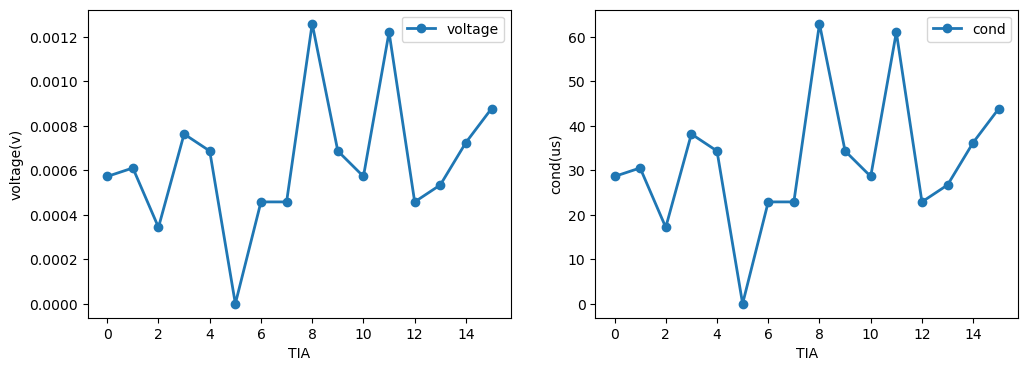

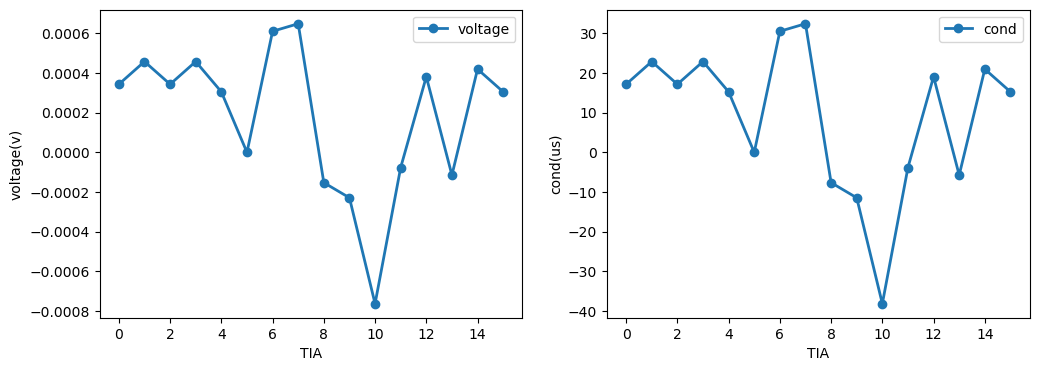

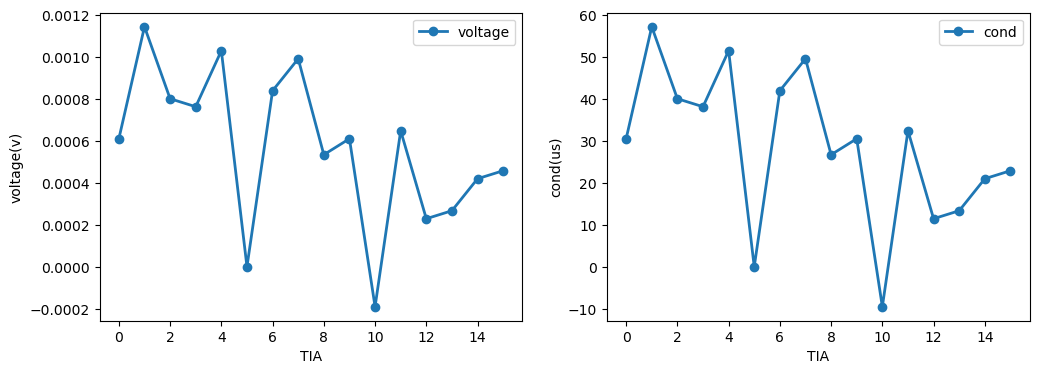

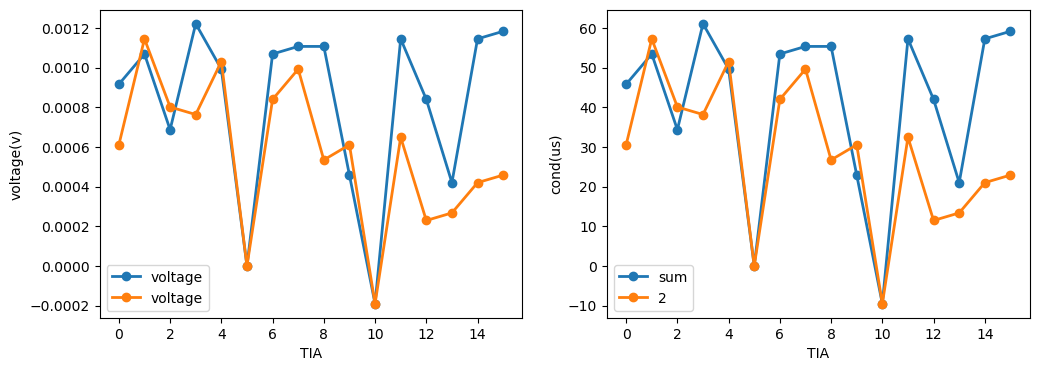

[ 0.00091556  0.00106815  0.00068667  0.00122074  0.00099185  0.
  0.00106815  0.0011063   0.0011063   0.00045778 -0.00019074  0.00114444
  0.00083926  0.00041963  0.00114444  0.00118259]
[ 0.00061037  0.00114444  0.00080111  0.00076296  0.00103     0.
  0.00083926  0.00099185  0.00053407  0.00061037 -0.00019074  0.00064852
  0.00022889  0.00026704  0.00041963  0.00045778]


In [367]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    voltage[5]=0
    cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

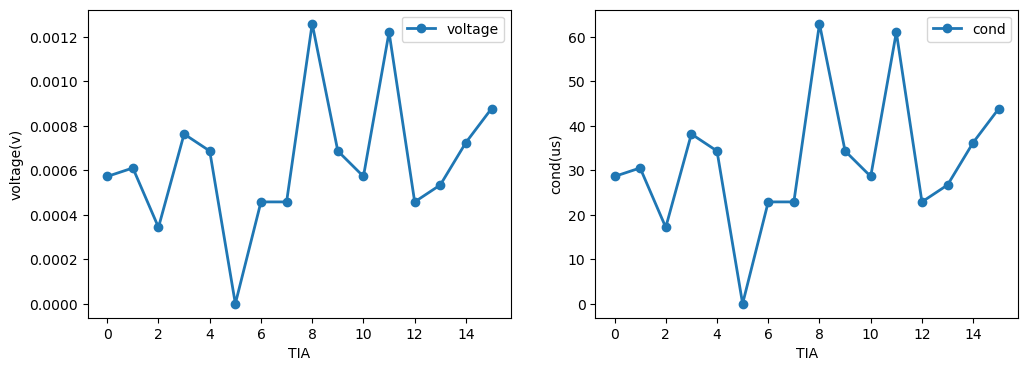

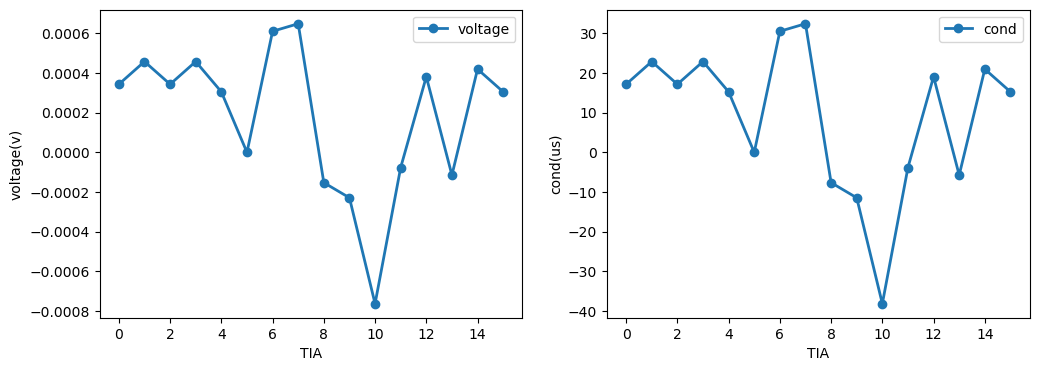

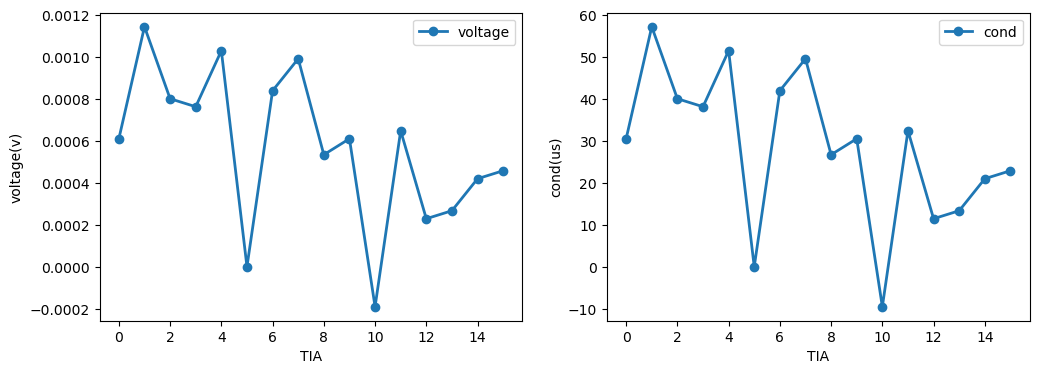

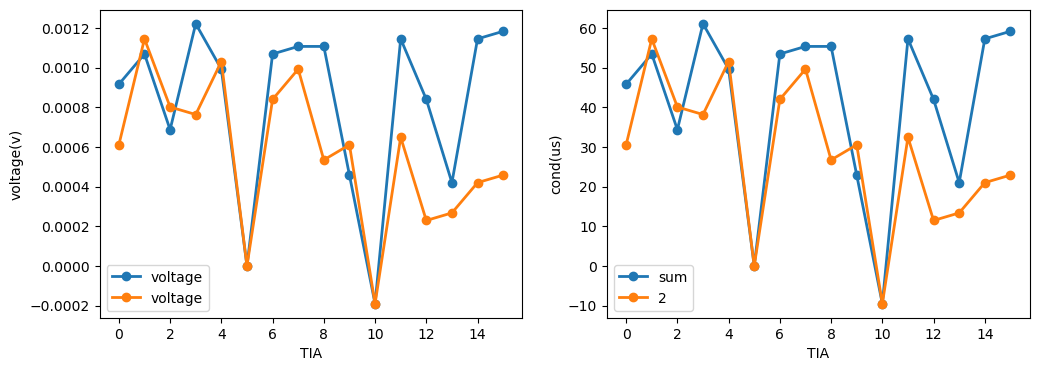

[ 0.00091556  0.00106815  0.00068667  0.00122074  0.00099185  0.
  0.00106815  0.0011063   0.0011063   0.00045778 -0.00019074  0.00114444
  0.00083926  0.00041963  0.00114444  0.00118259]
[ 0.00061037  0.00114444  0.00080111  0.00076296  0.00103     0.
  0.00083926  0.00099185  0.00053407  0.00061037 -0.00019074  0.00064852
  0.00022889  0.00026704  0.00041963  0.00045778]


In [368]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    voltage[5]=0
    cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

### 2.4.2 减法读bank-反

In [296]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [297]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [298]:
print(chip.get_setting_info())

操作模式：read	器件：ECRAM	读电压：0.1v	从行\列给电压：行	TIA增益：3


In [299]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [3],
    [7],
    [3,7],

    [0],
    [4],
    [0,4]
]
for num in read_row:
    chip.set_bank_latch(num,row=True,value=0)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     print(bank,bin(index))
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

In [ ]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

In [300]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [3],
    [7],
    [3,7],

    [0],
    [4],
    [0,4]
]
for num in read_row:
    chip.set_bank_latch(num,row=True,value=0)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     print(bank,bin(index))
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

[0.4729606  0.41833247 0.48306986 0.40208136 0.44961394 0.35637989
 0.42703024 0.48383282 0.47322764 0.46514023 0.43229469 0.41829432
 0.41627247 0.39975433 0.39094211 0.36866359]

[0.44682913 0.39571062 0.45716727 0.38033692 0.42470321 0.33940397
 0.40448469 0.45812098 0.44179357 0.43511765 0.40597247 0.39395581
 0.39304025 0.37724693 0.36927396 0.34817804]

[0.44385357 0.39300211 0.45342875 0.37766655 0.42115543 0.33852657
 0.40173803 0.45392468 0.44465468 0.43595691 0.40475173 0.39120914
 0.38979766 0.37236396 0.36297952 0.34020508]

[0.41707358 0.36957915 0.42619098 0.35508286 0.3952147  0.32086398
 0.37842952 0.42764061 0.41142766 0.40498062 0.377781   0.3655736
 0.36564989 0.34920804 0.34089175 0.31903287]

[0.43183691 0.38529618 0.44629505 0.3735847  0.41570025 0.3367336
 0.39723655 0.44991913 0.44045839 0.43259987 0.40200507 0.38872951
 0.38762322 0.37179174 0.36385693 0.34295175]

[0.45514542 0.40311136 0.46525468 0.38918729 0.43176061 0.34726249
 0.40898618 0.46189764 0.45712

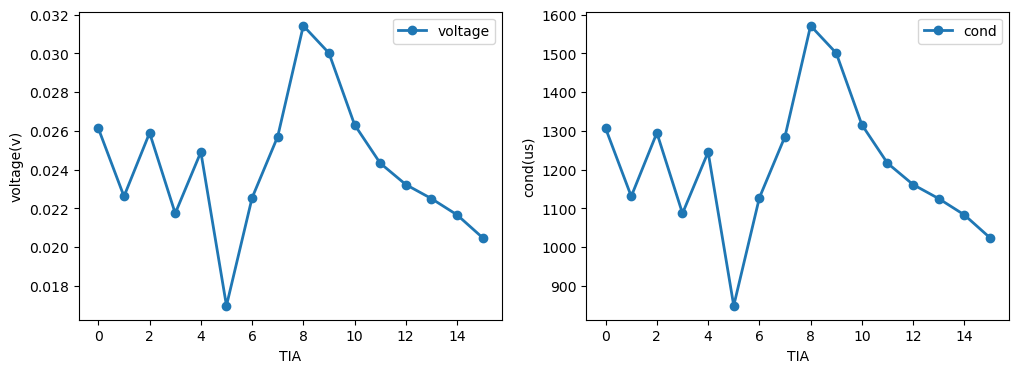

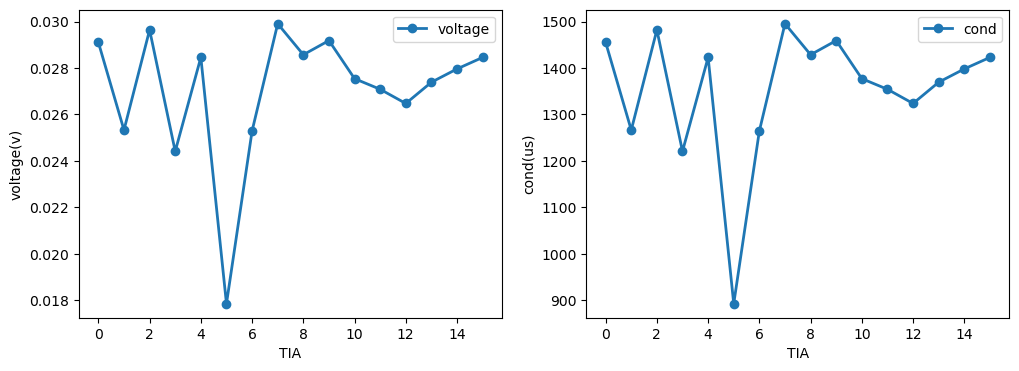

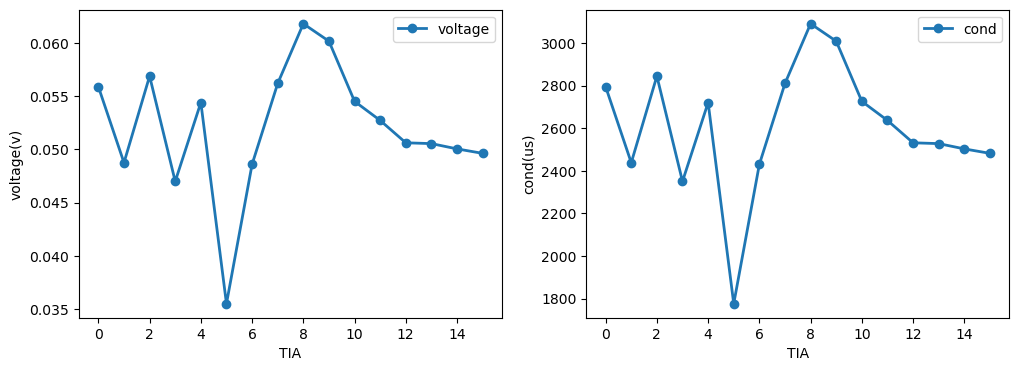

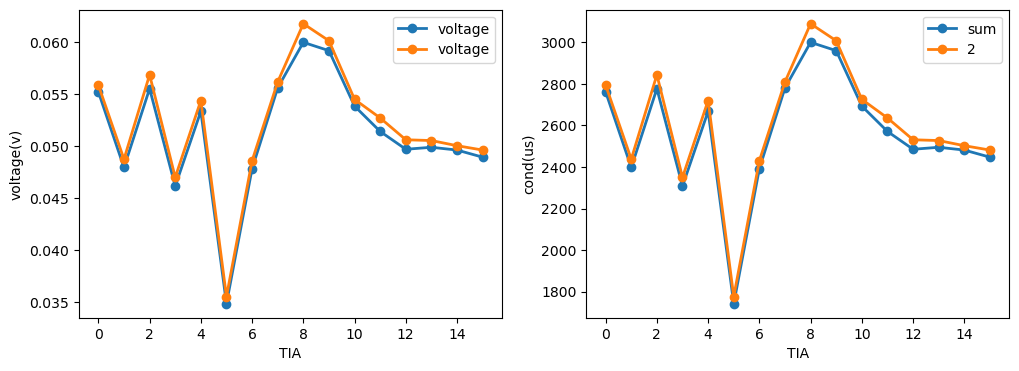

[0.0552385  0.04795221 0.05554369 0.04615925 0.05336924 0.03482925
 0.04783776 0.05561998 0.06000702 0.05920591 0.05386517 0.05142369
 0.04970702 0.04989776 0.04963073 0.04894406]
[0.05588702 0.04875332 0.05687887 0.0469985  0.05439924 0.03551592
 0.04860073 0.05619221 0.06179998 0.06015961 0.05451369 0.05272073
 0.05062258 0.05054628 0.05005036 0.04963073]


In [301]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

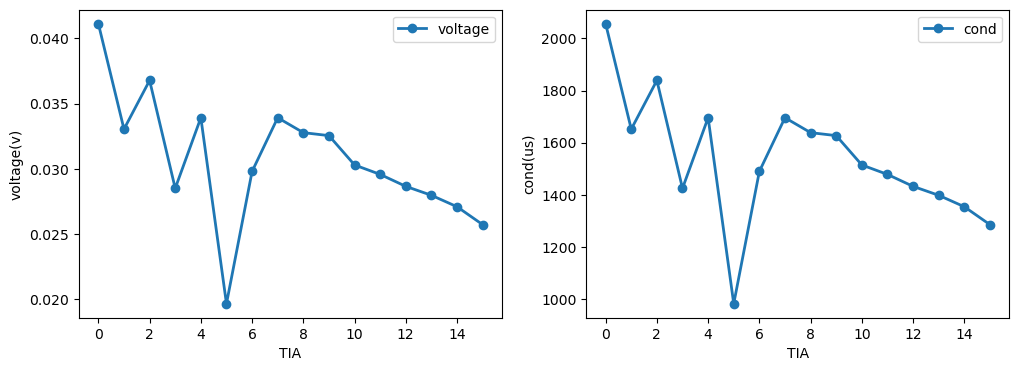

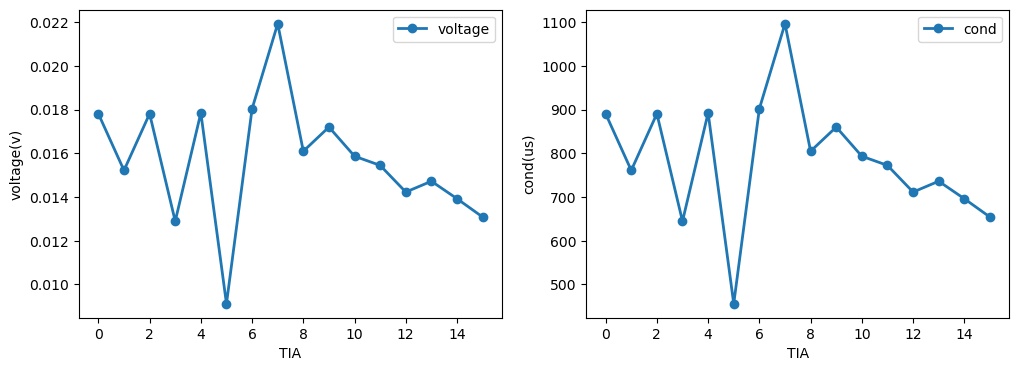

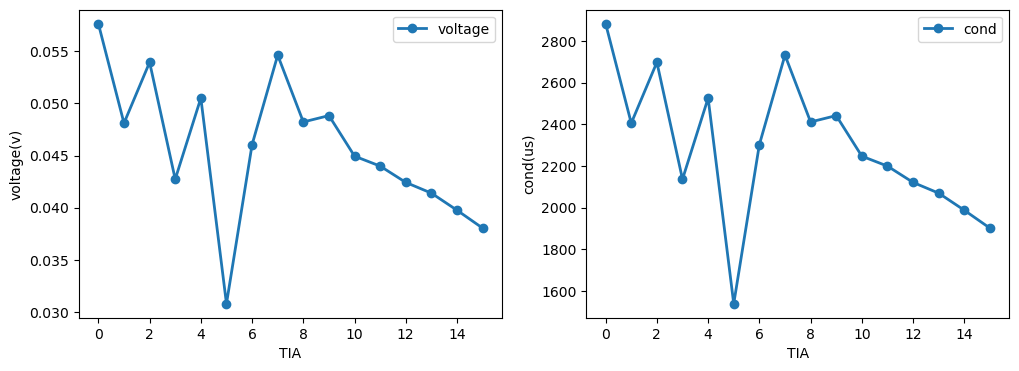

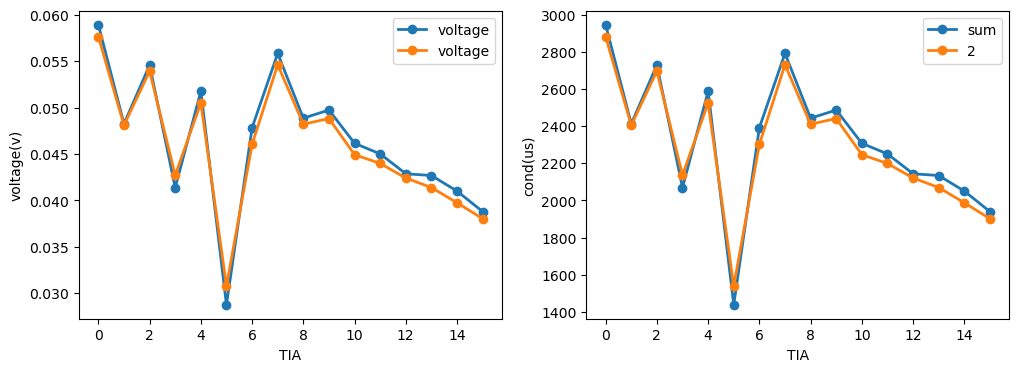

[0.0552385  0.04795221 0.05554369 0.04615925 0.05336924 0.03482925
 0.04783776 0.05561998 0.06000702 0.05920591 0.05386517 0.05142369
 0.04970702 0.04989776 0.04963073 0.04894406]
[0.05588702 0.04875332 0.05687887 0.0469985  0.05439924 0.03551592
 0.04860073 0.05619221 0.06179998 0.06015961 0.05451369 0.05272073
 0.05062258 0.05054628 0.05005036 0.04963073]


In [302]:
res_sub = [(cond_base-cond,voltage_base-voltage) for cond,voltage in res]
for cond,voltage in res_sub[3:]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[3][1]+res_sub[4][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_sub[5][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[3][0]+res_sub[4][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

### 2.4.3 正读

In [308]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.5)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [309]:
chip.set_cim_reset()
# chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [310]:
chip.generate_read_pulse()
cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

res = []
read_row=[
    [3],
    [7],
    [3,7],

    [0],
    [4],
    [0,4]
]
for num in read_row:
    chip.set_bank_latch(num,row=True,value=0xFFFF_FFFF)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     print(bank,bin(index))
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF^(index))

    chip.generate_read_pulse()
    tmp = chip.get_tia_out([k for k in range(16)])
    res.append(tmp)


    chip.set_bank_latch(num,row=True,value=0)
    # for i in num:
    #     bank,_ = chip.numToBank_Index(i[0])
    #     _,index = chip.get_data(i)
    #     chip.set_bank_latch([bank],row=True,value=0xFFFF_FFFF)

In [311]:
print(voltage_base)

for cond,voltage in res:
    print()
    print(voltage)

[ 0.00080111  0.00236518  0.00831629 -0.00515    -0.00503555 -0.00389111
  0.01590777  0.00854518  0.00221259  0.0021363   0.00267037  0.00442518
  0.00980407  0.00522629  0.00518815 -0.00335704]

[0.49771874 0.45098727 0.51473281 0.43328654 0.47898801 0.34531693
 0.44885098 0.50328837 0.55822169 0.53254799 0.48425245 0.45941801
 0.45091098 0.42714469 0.41318247 0.38598285]

[0.56527909 0.51419874 0.5885876  0.50035096 0.55604724 0.40391247
 0.52396466 0.59057131 0.57081057 0.56695761 0.53323466 0.52076022
 0.5262154  0.51499985 0.51534318 0.50557726]

[0.98666341 0.89548936 1.01683859 0.87393567 0.96865749 0.73675497
 0.89201788 1.00928526 1.04659413 1.01901303 0.9428312  0.90777306
 0.90033418 0.87149419 0.86020234 0.83388012]

[0.61841945 0.54410688 0.60544908 0.50721763 0.55375835 0.39254433
 0.50931578 0.57050539 0.55341502 0.54540391 0.507828   0.49127171
 0.48661763 0.46506394 0.45175024 0.42394024]

[0.34161657 0.31205176 0.36122471 0.30388806 0.34234138 0.25055696
 0.34203619 

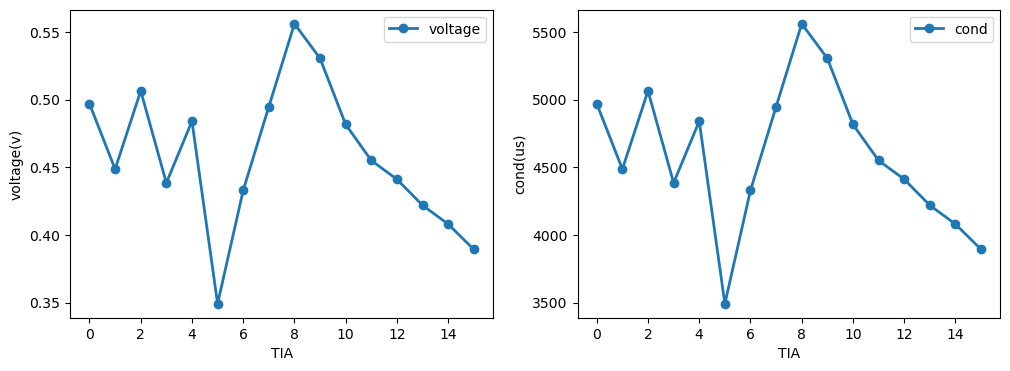

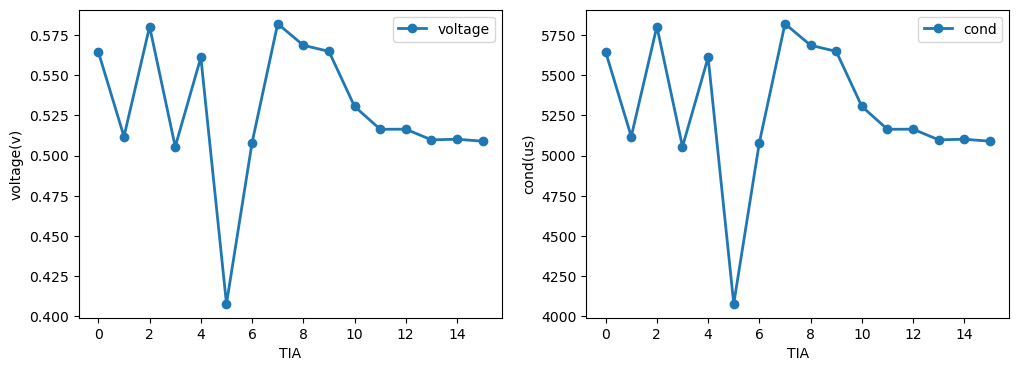

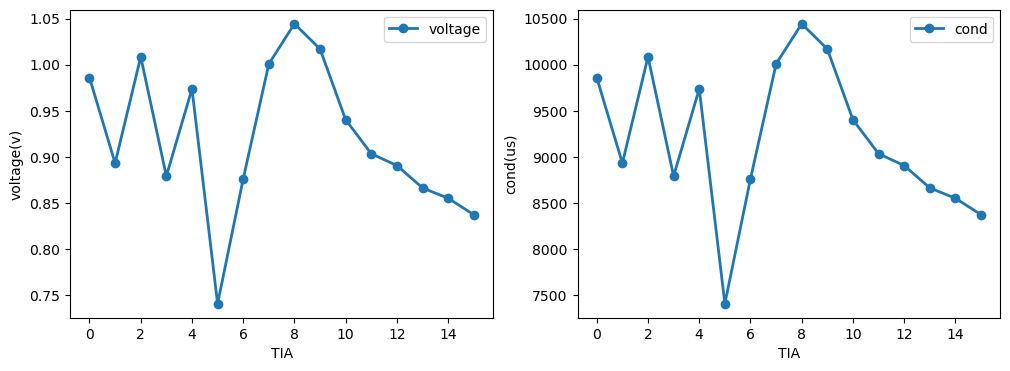

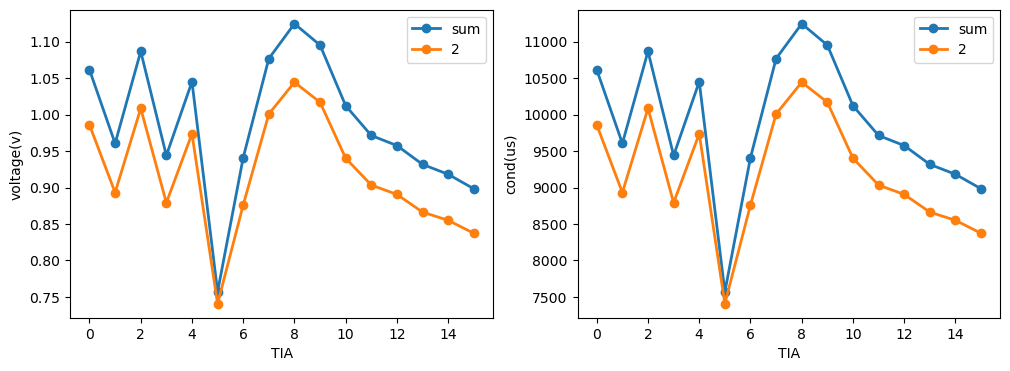

[1.06139561 0.96045564 1.08668783 0.9439375  1.04510636 0.75701163
 0.94100009 1.07676931 1.12460707 1.09523301 1.01214637 0.97132786
 0.95751823 0.93169195 0.91814936 0.89827418]
[0.9858623  0.89312418 1.00852229 0.87908567 0.97369304 0.74064608
 0.87611011 1.00074007 1.04438154 1.01687674 0.94016083 0.90334788
 0.89053011 0.86626789 0.85501419 0.83723716]


In [312]:
res_sub = [(cond-cond_base,voltage-voltage_base) for cond,voltage in res]
for cond,voltage in res_sub[:3]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[0][1]+res_sub[1][1],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][1],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()


plt.subplot(1,2,2)
plt.plot(res_sub[0][0]+res_sub[1][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[2][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[0][1]+res_sub[1][1])
print(res_sub[2][1])

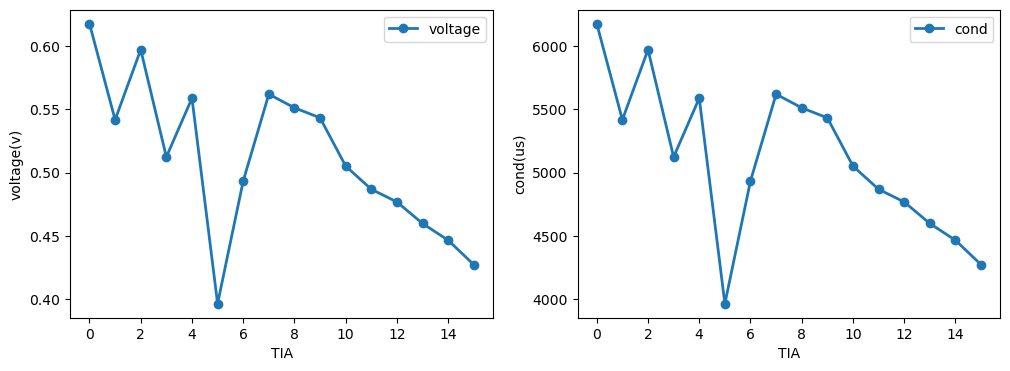

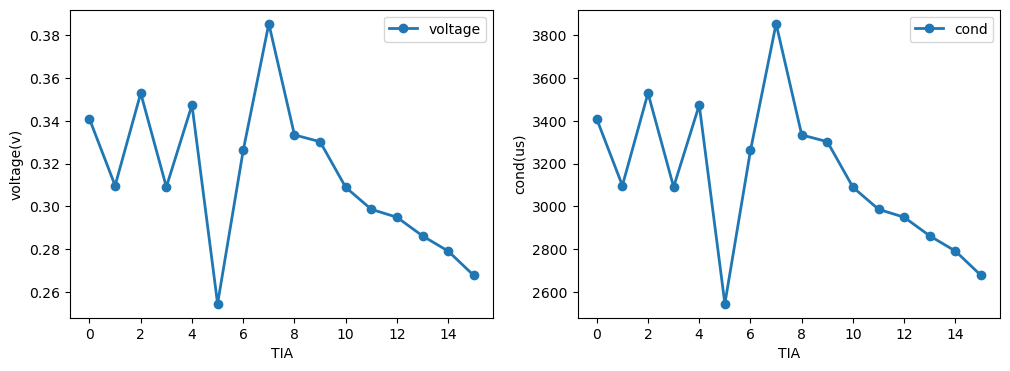

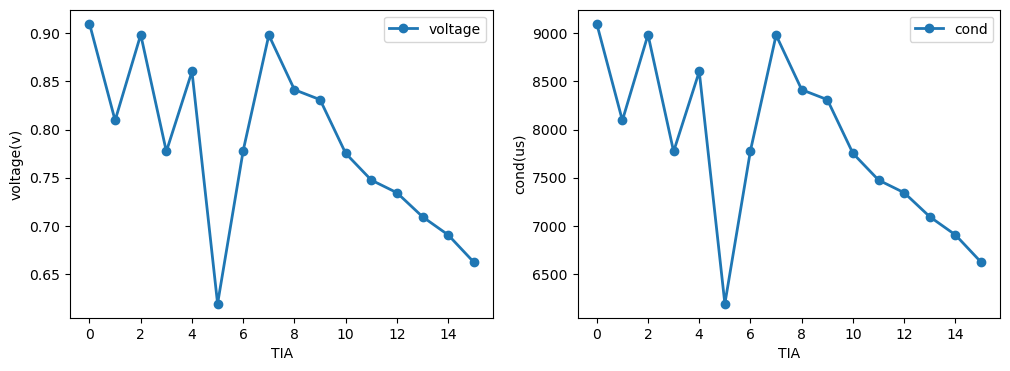

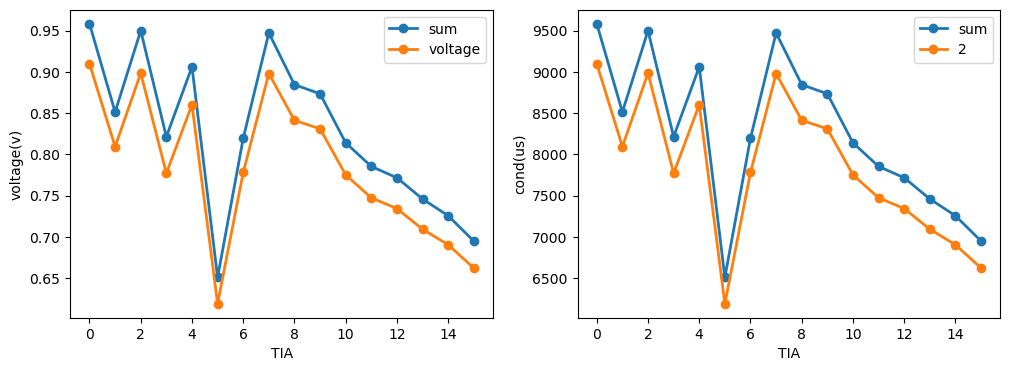

[0.95843379 0.85142827 0.9500412  0.82140568 0.90617084 0.65088351
 0.81953642 0.94733268 0.884579   0.87347789 0.81404309 0.78543199
 0.77169866 0.74598682 0.72561571 0.69494461]
[0.90990936 0.80942717 0.89854122 0.77715384 0.86027863 0.61899167
 0.77818384 0.89808344 0.84131901 0.83101901 0.77520829 0.74743645
 0.73431349 0.70932646 0.69048128 0.66217536]


In [313]:
res_sub = [(cond-cond_base,voltage-voltage_base) for cond,voltage in res]
for cond,voltage in res_sub[3:]:
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(voltage,marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(cond,marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_sub[3][1]+res_sub[4][1],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")
plt.legend()

plt.subplot(1,2,2)
plt.plot(res_sub[3][0]+res_sub[4][0],marker='o', linestyle='-', linewidth=2,label="sum")
plt.plot(res_sub[5][0],marker='o', linestyle='-', linewidth=2,label="2")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_sub[3][1]+res_sub[4][1])
print(res_sub[5][1])

### 2.4.2 只开一行，减法读一个器件

In [182]:
chip.set_device_cfg(deviceType=1)           # 第一步，设置器件
chip.set_read_mode(row=True)                # 第二步设置，从行读，还是从列读
chip.set_dac_read_V(0.1)                    # 第三步设置读写电压
chip.set_tia_gain(3)                        # 第四步设置，TIA增益

In [ ]:
chip.set_cim_reset()
chip.set_bank_latch([i for i in range(8)],row=True,value=0xFFFF_FFFF)
chip.set_bank_latch([i for i in range(8)],row=False,value=0xFFFF_FFFF)

In [183]:
res_cond = []
res_voltage = []
read_row=[
    [[181]],
    [[163]],
    [[181,163]]
]
chip.set_cim_reset()
# 
chip.set_bank_latch([i for i in range(8)],row=False,value=0x9999_9999)
for num in read_row:
    chip.set_latch(num,row=True,value=None)

    # 0v读一次
    chip.set_dac_read_V(0)
    chip.generate_read_pulse()
    cond_base,voltage_base = chip.get_tia_out([k for k in range(16)])

    # 0.1v读一次
    chip.set_dac_read_V(0.1)
    chip.generate_read_pulse()
    cond,voltage = chip.get_tia_out([k for k in range(16)])
    res_cond.append(cond-cond_base)
    res_voltage.append(voltage-voltage_base)

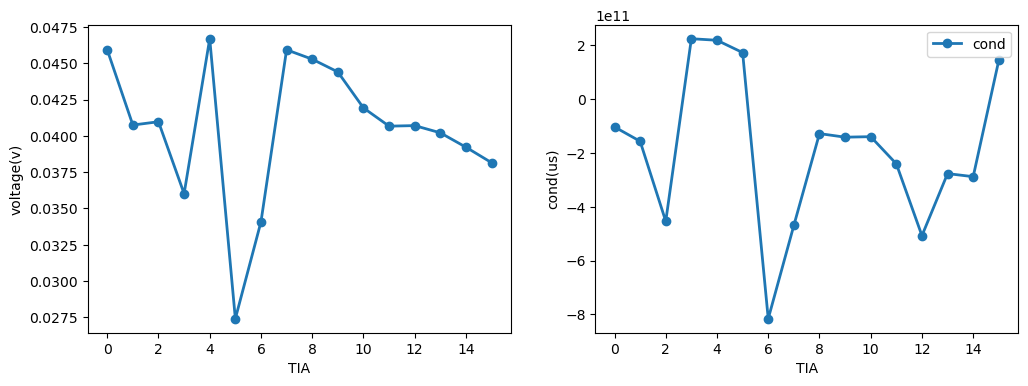

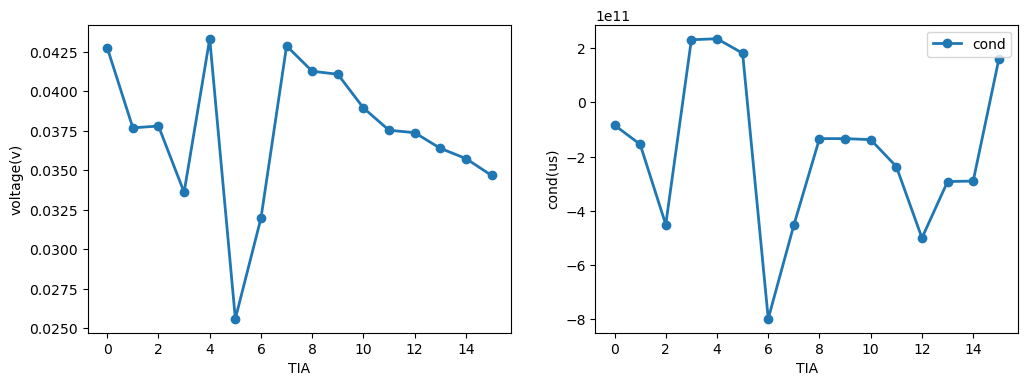

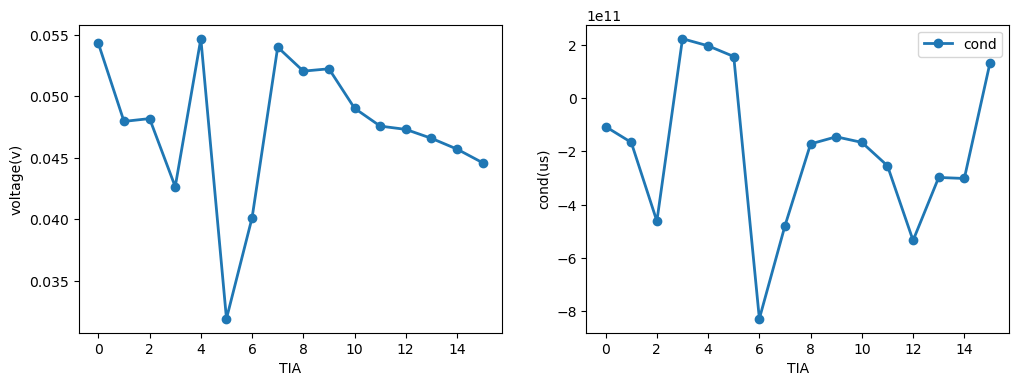

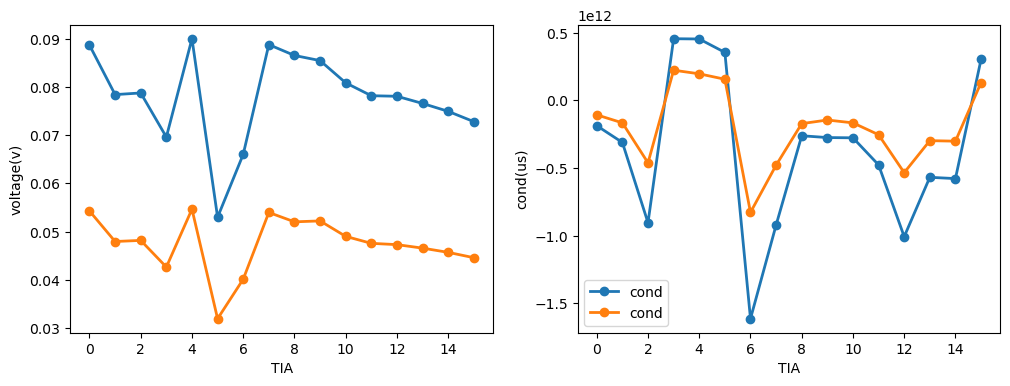

[-1.86925866e+11 -3.10907311e+11 -9.04110838e+11  4.55870238e+11
  4.53962833e+11  3.54777675e+11 -1.61366618e+12 -9.21277499e+11
 -2.61314733e+11 -2.74666581e+11 -2.76573988e+11 -4.76851706e+11
 -1.00711081e+12 -5.68407235e+11 -5.77944269e+11  3.03277691e+11]
[-1.06814780e+11 -1.65944393e+11 -4.61592453e+11  2.23166602e+11
  1.96462907e+11  1.56407363e+11 -8.27814567e+11 -4.78759114e+11
 -1.71666613e+11 -1.44962917e+11 -1.65944393e+11 -2.53685107e+11
 -5.34073913e+11 -2.97555465e+11 -3.01370278e+11  1.31611074e+11]


In [186]:
for k in range(len(res_cond)):
    # voltage[5]=0
    # cond[5]=0
    # voltage[6]=0
    # cond[6]=0
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res_voltage[k],marker='o', linestyle='-', linewidth=2,label="voltage")
    plt.ylabel("voltage(v)")
    plt.xlabel("TIA")

    plt.subplot(1,2,2)
    plt.plot(res_cond[k],marker='o', linestyle='-', linewidth=2,label="cond")
    plt.ylabel("cond(us)")
    plt.xlabel("TIA")

    plt.legend()
    plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(res_voltage[0]+res_voltage[1],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.plot(res_voltage[2],marker='o', linestyle='-', linewidth=2,label="voltage")
plt.ylabel("voltage(v)")
plt.xlabel("TIA")

plt.subplot(1,2,2)
plt.plot(res_cond[0]+res_cond[1],marker='o', linestyle='-', linewidth=2,label="cond")
plt.plot(res_cond[2],marker='o', linestyle='-', linewidth=2,label="cond")
plt.ylabel("cond(us)")
plt.xlabel("TIA")

plt.legend()
plt.show()

print(res_cond[0]+res_cond[1])
print(res_cond[2])